In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

O comando **%matplotlib inline** é uma mágica do IPython usada em notebooks Jupyter. Quando você adiciona esse comando em uma célula de código, ele permite que gráficos gerados com a biblioteca matplotlib sejam exibidos diretamente no notebook, logo abaixo da célula que os gerou. Essa mágica facilita a visualização imediata dos gráficos sem a necessidade de chamar plt.show() explicitamente.
Em ambientes de script (como o VS Code), esse comando não é necessário, pois o comportamento de exibir ou não o gráfico é controlado por plt.show() diretamente.

**pip install numpy** -> Para instalar o numpy

**pip install tensorflow** -> instalará o TensorFlow, que inclui o Keras. Caso você queira apenas a versão independente de Keras: **pip install keras**

**pip install matplotlib** -> Para instlar o matplotlib

In [2]:
import zipfile

zip_file = "G:/Meu Drive/cats_and_dogs.zip"
extract_path = "G:/Meu Drive/cats_and_dogs"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extração concluída.")


Extração concluída.


Esse é o dataset usado: https://www.microsoft.com/en-us/download/details.aspx?id=54765

Para poupar armazenamento, salvei o dataset no google drive e usando o google drive desktop eu o sincronei para o sistema

In [3]:
root = extract_path
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['G:/Meu Drive/cats_and_dogs\\PetImages', 'G:/Meu Drive/cats_and_dogs\\PetImages\\Cat', 'G:/Meu Drive/cats_and_dogs\\PetImages\\Dog']


**root = extract_path** -> Define a pasta onde os dados estão armazenados

**train_split, val_split = 0.7, 0.15** -> Define a divisão dos dados: 70% para treinamento e 15% para validação. O restante será para teste.

**categories = [x[0] for x in os.walk(root) if x[0]][1:]** -> A função os.walk(root) gera uma lista de tuplas representando o conteúdo do diretório e subdiretórios. A primeira entrada de categories é o próprio diretório raiz, então [1:] remove esse primeiro elemento, listando apenas as subpastas, que correspondem às categorias (ex.: 'cats' e 'dogs').

In [4]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError 

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_image(path):
    try:
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except (UnidentifiedImageError, OSError) as e:  
        print(f"Skipping file {path} due to error: {e}")
        return None, None  

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        if img is not None:  
            data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

Skipping file G:/Meu Drive/cats_and_dogs\PetImages\Cat\666.jpg due to error: cannot identify image file <_io.BytesIO object at 0x000002B6EF4CEE30>
Skipping file G:/Meu Drive/cats_and_dogs\PetImages\Cat\666.jpg due to error: cannot identify image file <_io.BytesIO object at 0x000002B6EF4CEE30>


Antes de rodar esse codigo, intale o Pillou com **pip install Pillow**, que é uma biblioteca para manipulação de imagens em Python. 

**Função get_image:**

**image.load_img(path, target_size=(224, 224)):** Carrega a imagem no caminho path e a redimensiona para 224x224 pixels, que é o tamanho esperado para as entradas de VGG16.

**image.img_to_array(img):** Converte a imagem para um array NumPy, necessário para alimentar redes neurais.

**np.expand_dims(x, axis=0):** Expande as dimensões do array para que ele tenha o formato (1, 224, 224, 3), compatível com o formato de entrada de redes neurais.

**preprocess_input(x):** Pré-processa a imagem de acordo com os requisitos do modelo VGG16 (normaliza os valores de pixel de acordo com a forma que o VGG16 foi treinado).

Se ocorrer um erro ao carregar a imagem (como um arquivo corrompido ou um formato de imagem inválido), ele captura e imprime o erro, e retorna None, None.

**Preparação dos dados:** 

Inicializa uma lista data para armazenar os dados das imagens.

Para cada categoria de imagem (como 'cats' ou 'dogs'), ele percorre o diretório e encontra todos os arquivos de imagem (.jpg, .png, .jpeg) com os.walk.

Para cada imagem encontrada, chama a função get_image(img_path) para carregá-la e pré-processá-la.

Se a imagem for carregada corretamente (img is not None), ela é adicionada à lista data como um dicionário com a chave 'x' contendo a imagem pré-processada (x[0]) e a chave 'y' contendo o índice da categoria (c).

**num_classes = len(categories)** -> Define o número de classes (categorias de imagem) com base na lista categories, que foi obtida anteriormente.

**Explicação geral:**

O código prepara um conjunto de dados de imagens para treinamento de um modelo de aprendizado de máquina, realizando as seguintes tarefas:

Carrega as imagens de diretórios específicos.

Pré-processa as imagens para que elas possam ser usadas em um modelo de transferência de aprendizado.

Organiza as imagens e suas respectivas categorias em um formato adequado para alimentar um modelo de aprendizado de máquina.

In [5]:
random.shuffle(data)

Aleatoriza a ordem da data

In [6]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Esse código divide o conjunto de dados data de acordo com as proporções definidas em train_split (porcentagem para treinamento), val_split (porcentagem para validação) e o restante (para o teste). O resultado são três subconjuntos:

**Treinamento (train)**: Usa 70% dos dados para treinar o modelo. 

**Validação (val)**: Usa 15% dos dados para ajustar hiperparâmetros e monitorar o modelo durante o treinamento.

**Teste (test)**: Usa 15% dos dados para avaliar a performance do modelo após o treinamento.

In [7]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 

Esse código converte as listas de treino, validação e teste em arrays NumPy, facilitando o uso desses dados com os frameworks.

**x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]:**

x_train: Cria um array NumPy contendo todas as imagens da lista train. Cada imagem foi processada anteriormente e armazenada em t["x"], que é a representação da imagem ajustada para a entrada do modelo.

y_train: Cria uma lista com os rótulos (y) das classes associadas a cada imagem na lista train.

**x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]:**

x_val: Similar ao x_train, mas para o conjunto de validação. Converte as imagens no conjunto val em um array NumPy.

y_val: Coleta os rótulos das imagens no conjunto de validação.

**x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]:**

x_test: Cria o array NumPy com as imagens do conjunto de teste.

y_test: Coleta os rótulos das imagens no conjunto de teste.

In [8]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(601, 3)


Esse código é uma etapa de pré-processamento importante para preparar os dados em um formato que as redes neurais esperam, tanto no que diz respeito aos valores normalizados dos pixels quanto ao formato dos rótulos para classificação multiclasse.

**x_train = x_train.astype('float32') / 255.:**

Converte os valores dos pixels em x_train para o tipo float32 e divide cada valor por 255.
Essa divisão normaliza os valores dos pixels para o intervalo [0, 1] (já que originalmente os valores dos pixels variam de 0 a 255). A normalização facilita o treinamento da rede neural, pois reduz a variabilidade dos valores de entrada.

**x_val = x_val.astype('float32') / 255.:**

Realiza o mesmo processo de normalização para o conjunto de validação (x_val), garantindo que as imagens de validação estejam no mesmo intervalo de valores que as imagens de treino.

**x_test = x_test.astype('float32') / 255.:**

Normaliza o conjunto de teste (x_test) da mesma forma, para que todos os conjuntos de dados (treino, validação e teste) tenham o mesmo intervalo de valores.

**y_train = keras.utils.to_categorical(y_train, num_classes):**

Converte y_train, que originalmente é uma lista de inteiros (onde cada inteiro representa uma classe), para um formato de one-hot encoding.

O one-hot encoding cria um vetor binário para cada rótulo, onde apenas a posição correspondente à classe tem o valor 1 e todas as outras posições têm 0. Por exemplo, se houver 3 classes e uma amostra pertence à classe 1, o vetor seria [0, 1, 0].

num_classes especifica o número total de classes. Isso é útil para modelos de classificação, pois facilita o cálculo da perda categórica durante o treinamento.

**y_val = keras.utils.to_categorical(y_val, num_classes):**

Converte y_val para one-hot encoding no conjunto de validação, aplicando o mesmo processo para garantir que o formato dos rótulos de validação seja compatível com o modelo.

**y_test = keras.utils.to_categorical(y_test, num_classes):**

Converte y_test para one-hot encoding no conjunto de teste, para que o formato dos rótulos do teste também seja compatível com o modelo durante a avaliação.

In [9]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 4002 images from 3 categories
train / validation / test split: 2801, 600, 601
training data shape:  (2801, 224, 224, 3)
training labels shape:  (2801, 3)


Esse trecho de código exibe informações sobre o carregamento e a divisão dos dados:

**print("finished loading %d images from %d categories"%(len(data), num_classes)):**

Informa quantas imagens foram carregadas (len(data)) e quantas categorias estão presentes (num_classes).

**print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test))):**

Mostra o número de amostras em cada conjunto: treino (len(x_train)), validação (len(x_val)) e teste (len(x_test)).

**print("training data shape: ", x_train.shape):**

Exibe as dimensões do conjunto de treino, indicando o formato dos dados de entrada.

**print("training labels shape: ", y_train.shape):**

Exibe as dimensões dos rótulos do conjunto de treino, confirmando o formato dos rótulos após o one-hot encoding.

Essas informações são úteis para verificar se o carregamento e a divisão dos dados ocorreram corretamente.

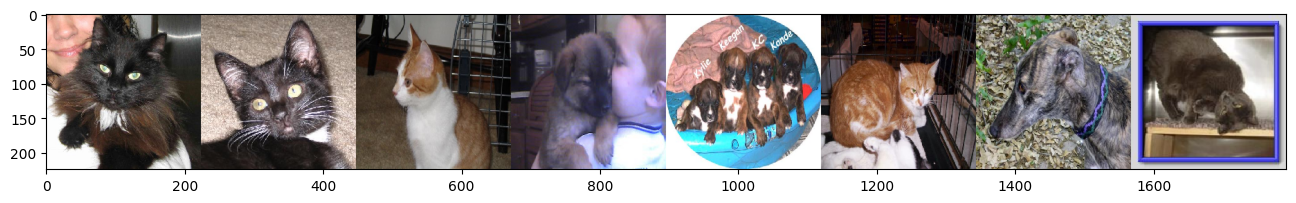

In [10]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Esse trecho de código seleciona algumas imagens aleatórias do conjunto de dados e as exibe em uma única linha, concatenando-as em uma imagem longa. Aqui está a explicação passo a passo:

**images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]:**

Gera uma lista (images) com os caminhos de todas as imagens nos formatos .jpg, .png e .jpeg encontradas na pasta root e suas subpastas.

**idx = [int(len(images) * random.random()) for i in range(8)]:**

Cria uma lista de índices aleatórios (idx) para selecionar 8 imagens aleatórias da lista images. Cada índice é gerado multiplicando um número aleatório entre 0 e 1 pelo tamanho total da lista images.

**imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]:**

Carrega as imagens selecionadas aleatoriamente em imgs, redimensionando cada uma para 224x224 pixels para padronização.

**concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1):**

Converte as imagens carregadas para arrays NumPy e as concatena horizontalmente (usando axis=1), formando uma única imagem longa composta por 8 imagens lado a lado.

**plt.figure(figsize=(16,4)):**

Define o tamanho da figura que será exibida, com 16 de largura e 4 de altura.

**plt.imshow(concat_image):**

Exibe a imagem concatenada.

In [11]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


C:\Users\Erike\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,315 (4.61 MB)

 Trainable params: 1,209,315 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Esse código define uma rede neural convolucional (CNN) utilizando a biblioteca Keras para classificação de imagens. Esse modelo é uma CNN clássica, com camadas convolucionais para extração de características e camadas densas para realizar a classificação. A arquitetura é projetada para processar imagens de entrada com dimensões (224, 224, 3) e produzir previsões para num_classes diferentes categorias. As técnicas de pooling e dropout ajudam na regularização e eficiência.

**Inicialização do modelo**

model = Sequential()

print("Input dimensions: ",x_train.shape[1:])

O modelo é definido como sequencial, ou seja, as camadas são empilhadas uma após a outra em sequência.

O formato de entrada das imagens é obtido a partir do shape de x_train (imagens de entrada), ignorando o número de amostras (primeira dimensão).

**Primeira camada convolucional**

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

**Conv2D(32, (3, 3)):** Adiciona 32 filtros convolucionais de tamanho 3x3 que extraem características da imagem.

**input_shape=x_train.shape[1:]:** Define o formato da entrada para a primeira camada (dimensões da imagem: altura, largura e canais).

**Activation('relu'):** Aplica a função de ativação ReLU (Rectified Linear Unit), que substitui valores negativos por zero, introduzindo não-linearidade.

**MaxPooling2D(pool_size=(2, 2)):** Reduz a dimensionalidade (altura e largura) pela metade usando um pooling máximo com uma janela 2x2.

**Segunda camada convolucional**

model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

Repete o processo com outra camada convolucional, aplicando 32 filtros 3x3.

O pooling reduz ainda mais as dimensões da imagem processada.

**Dropout**

model.add(Dropout(0.25))

Dropout(0.25): Durante o treinamento, desativa aleatoriamente 25% dos neurônios desta camada para evitar overfitting.

**Terceira e quarta camadas convolucionais**

model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

Adiciona mais duas camadas convolucionais seguidas de pooling, continuando a extração de características mais detalhadas.

**Outro Dropout**

model.add(Dropout(0.25))

Desativa novamente 25% dos neurônios para evitar overfitting.

**Camada de Flatten**

model.add(Flatten())

Transforma os dados em um vetor unidimensional para que possam ser usados em camadas densas (totalmente conectadas).

**Camada densa (fully connected)**

model.add(Dense(256))

model.add(Activation('relu'))

Dense(256): Adiciona uma camada com 256 neurônios totalmente conectados.

Activation('relu'): Introduz não-linearidade.

**Dropout**

model.add(Dropout(0.5))

Desativa aleatoriamente 50% dos neurônios desta camada, reforçando a regularização.

**Camada de saída**

model.add(Dense(num_classes))

model.add(Activation('softmax'))

Dense(num_classes): Define o número de neurônios igual ao número de classes (uma para cada classe do problema de classificação).

Activation('softmax'): Calcula as probabilidades para cada classe. A soma das probabilidades será 1, tornando-o adequado para classificação multiclasse.

**Resumo do modelo**

model.summary()

Exibe um resumo do modelo, incluindo o número de parâmetros treináveis e a estrutura completa (camadas, formatos de saída, etc.).


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 983ms/step - accuracy: 0.4687 - loss: 1.0781 - val_accuracy: 0.5200 - val_loss: 1.0418
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 981ms/step - accuracy: 0.4978 - loss: 1.0411 - val_accuracy: 0.5200 - val_loss: 1.0496
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 954ms/step - accuracy: 0.4989 - loss: 1.0418 - val_accuracy: 0.5200 - val_loss: 1.0299
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 969ms/step - accuracy: 0.4949 - loss: 1.0258 - val_accuracy: 0.5200 - val_loss: 1.0204
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 967ms/step - accuracy: 0.5141 - loss: 1.0099 - val_accuracy: 0.5150 - val_loss: 1.0171
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 951ms/step - accuracy: 0.4974 - loss: 1.0077 - val_accuracy: 0.5167 - val_loss: 0.9967
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 960ms/step - accuracy: 0.5024 - loss: 0.9982 - val_accuracy: 0.5050 - val_loss: 1.0085
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 973ms/step - accuracy: 0.4874 - loss: 0.9917 - val_accu

Esse código configura e treina o modelo criado anteriormente.

O modelo é configurado para otimizar os pesos com o Adam, minimizando o erro com base na função de perda categorical crossentropy.
Em seguida, é treinado por 10 épocas com lotes de 128 imagens cada, avaliando sua performance em dados de validação após cada época. O progresso do treinamento é armazenado na variável history.

**Configuração do modelo com model.compile()**

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**loss='categorical_crossentropy':** Define a função de perda (loss) usada para medir o erro entre as previsões do modelo e os valores reais.
A função categorical crossentropy é apropriada para problemas de classificação multiclasse, onde cada amostra pertence a uma única classe e os rótulos estão em formato one-hot encoding.

**optimizer='adam':** O otimizador Adam (Adaptive Moment Estimation) ajusta os pesos da rede durante o treinamento. É amplamente utilizado por sua eficiência em tarefas de deep learning, combinando as vantagens do momentum e da descida do gradiente adaptativa.

**metrics=['accuracy']:** Define as métricas que o modelo avaliará durante o treinamento e teste. Aqui, a métrica é a acurácia (proporção de previsões corretas).

**Treinamento do modelo com model.fit()**

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

**x_train e y_train:** Dados de treinamento (imagens e rótulos, respectivamente).

**batch_size=128:** Define o tamanho dos lotes (batches). Aqui, o modelo processa 128 amostras por vez antes de atualizar os pesos. Um tamanho de lote maior consome mais memória, enquanto um menor reduz a eficiência do treinamento.

**epochs=10:** O número de épocas define quantas vezes o modelo processará o conjunto de treinamento completo. Uma época corresponde a uma passagem completa pelos dados.

**validation_data=(x_val, y_val):** Dados de validação (imagens e rótulos). Após cada época, o modelo avalia sua performance nesses dados, que não são usados para atualizar os pesos. Serve para monitorar o overfitting.

**history:** Armazena o histórico do treinamento, incluindo métricas como perda e acurácia para os conjuntos de treinamento e validação em cada época. Isso pode ser usado para visualizações ou análises posteriores.

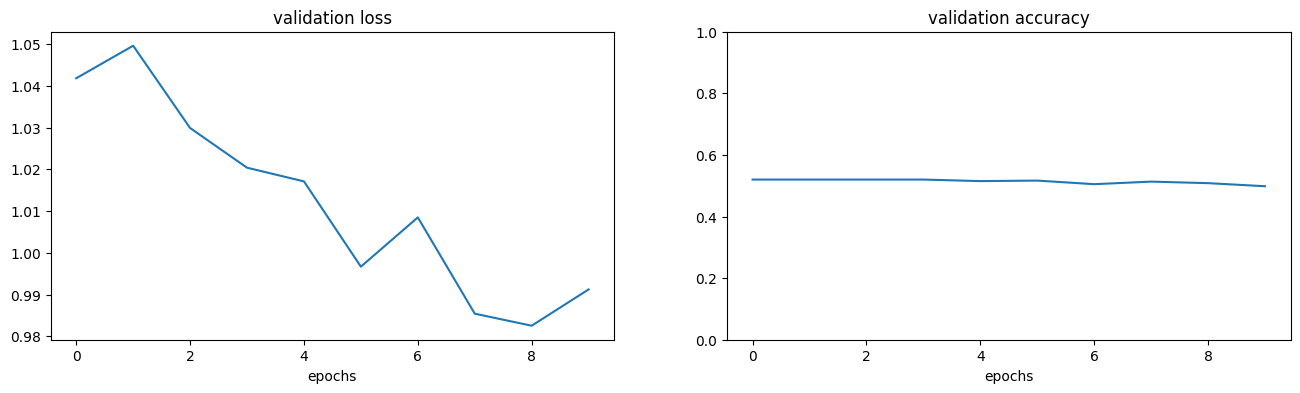

In [13]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Este código é usado para visualizar o desempenho do modelo durante o treinamento, especificamente a perda (loss) e a acurácia (accuracy) nos dados de validação ao longo das épocas.

Plota dois gráficos em uma única figura.

O gráfico da esquerda mostra a perda de validação (validation loss) ao longo das épocas.

O gráfico da direita mostra a acurácia de validação (validation accuracy) ao longo das épocas.

Fornece uma visualização clara do desempenho do modelo, ajudando a identificar tendências como overfitting (se a perda de validação aumenta enquanto a acurácia de validação para de melhorar).

**Criação da figura**

fig = plt.figure(figsize=(16,4))

**figsize=(16,4)**: Define o tamanho da figura em polegadas (16 de largura e 4 de altura). Isso cria espaço suficiente para exibir dois gráficos lado a lado.

**Gráfico da perda de validação**

ax = fig.add_subplot(121)

ax.plot(history.history["val_loss"])

ax.set_title("validation loss")

ax.set_xlabel("epochs")

**fig.add_subplot(121):** Adiciona um gráfico ao lado esquerdo da figura. O parâmetro 121 significa que há 1 linha, 2 colunas e este é o 1º gráfico.

**ax.plot(history.history["val_loss"]):** Plota a perda de validação (val_loss) registrada durante o treinamento. O history.history["val_loss"] contém os valores da perda de validação para cada época.

**ax.set_title("validation loss"):** Define o título do gráfico como "validation loss".

**ax.set_xlabel("epochs"):** Define o rótulo do eixo X como "epochs", já que a perda está sendo plotada ao longo das épocas.

**Gráfico da acurácia de validação**

ax2 = fig.add_subplot(122)

ax2.plot(history.history["val_accuracy"])

ax2.set_title("validation accuracy")

ax2.set_xlabel("epochs")

ax2.set_ylim(0, 1)

**fig.add_subplot(122):** Adiciona um gráfico ao lado direito da figura. O parâmetro 122 significa que há 1 linha, 2 colunas e este é o 2º gráfico.

**ax2.plot(history.history["val_accuracy"]):** Plota a acurácia de validação (val_accuracy) registrada durante o treinamento. O history.history["val_accuracy"] contém os valores da acurácia de validação para cada época.

**ax2.set_title("validation accuracy"):** Define o título do gráfico como "validation accuracy".

**ax2.set_xlabel("epochs"):** Define o rótulo do eixo X como "epochs", pois a acurácia está sendo plotada ao longo das épocas.

**ax2.set_ylim(0, 1):** Define o limite do eixo Y de 0 a 1, já que a acurácia varia nessa faixa.

**Exibição do gráfico**

plt.show()

**plt.show():** Exibe a figura criada com os dois gráficos.

In [14]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.9891218543052673
Test accuracy: 0.49417635798454285


Esse código avalia o desempenho do modelo treinado usando o conjunto de teste (test set). 

Objetivo: Avaliar a capacidade do modelo de generalizar para novos dados.

loss: Mede o erro do modelo em relação aos rótulos reais no conjunto de teste.

accuracy: Mede a proporção de previsões corretas realizadas pelo modelo.

**Avaliação do modelo**

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

**x_test:** Dados de entrada do conjunto de teste.

**y_test:** Rótulos correspondentes no formato categórico (one-hot encoded) para o conjunto de teste.

**verbose=0:** Suprime a saída padrão do progresso da avaliação. Pode ser ajustado para 1 ou 2 se quiser ver mais informações sobre o processo.

Os valores calculados são retornados como uma tupla: (loss, accuracy).

**Exibição da perda no conjunto de teste**

print('Test loss:', loss)

Exibe o valor da loss calculada no conjunto de teste.

Este valor indica o quão bem o modelo conseguiu minimizar os erros para os dados que ele não viu durante o treinamento.

**Exibição da acurácia no conjunto de teste**

print('Test accuracy:', accuracy)

Exibe o valor da acurácia calculada no conjunto de teste.

Este valor mostra o percentual de previsões corretas feitas pelo modelo ao avaliar os dados do conjunto de teste.

In [15]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Esse código utiliza o modelo VGG16 pré-treinado, que faz parte da biblioteca Keras, e exibe um resumo de sua arquitetura.

Ele inicializa o modelo VGG16 pré-treinado com pesos do ImageNet e exibe sua estrutura.

O VGG16 é uma rede profunda com 16 camadas treináveis (convolucionais e densas), projetada para tarefas de classificação de imagens.

**Importação do modelo VGG16**

vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

**keras.applications.VGG16:** É uma implementação do modelo VGG16, uma rede neural convolucional profunda desenvolvida pela Visual Geometry Group.
Ela foi originalmente treinada no conjunto de dados ImageNet, que contém milhões de imagens de diversas categorias.
Parâmetros:

**weights='imagenet':** Carrega os pesos do modelo pré-treinado no conjunto de dados ImageNet.
Isso permite reutilizar as características já aprendidas pela rede em tarefas de classificação genéricas.

**include_top=True:** Inclui a parte final do modelo (camadas densas fully-connected e a camada de saída com a função softmax).
Isso é importante quando você deseja usar o modelo completo para prever categorias no ImageNet.


**Exibição do resumo da arquitetura**

vgg.summary()

Mostra um resumo detalhado da arquitetura do modelo, incluindo:
O nome e o tipo de cada camada,
a saída de cada camada (formato de tensor),
o número de parâmetros treináveis em cada camada,
o total de parâmetros no modelo.

In [ ]:
inp = vgg.input

new_classification_layer = Dense(num_classes, activation='softmax')

out = new_classification_layer(vgg.layers[-2].output)

model_new = Model(inp, out)

Esse código cria um novo modelo baseado na arquitetura do VGG16, ajustando sua saída para uma nova tarefa de classificação.

Ele aproveita o VGG16 pré-treinado como uma base para extração de características.

A camada de classificação original do VGG16 é substituída por uma nova camada personalizada para o problema.

O novo modelo, model_new, pode ser treinado em dados específicos para adaptar o VGG16 à nova tarefa.

**Obter a entrada original do modelo VGG16**

inp = vgg.input

**vgg.input:** É a camada de entrada do modelo VGG16 original. Ela define o formato esperado das imagens de entrada, que é (224, 224, 3) (imagens coloridas de 224x224 pixels).

**Criar uma nova camada de classificação**

new_classification_layer = Dense(num_classes, activation='softmax')

**Dense(num_classes, activation='softmax'):** Cria uma camada densa (fully-connected) que será a nova camada de saída do modelo.

**num_classes:** Define o número de categorias no problema de classificação. Essa camada terá num_classes neurônios, cada um representando uma probabilidade para uma classe.

**activation='softmax':** A função softmax converte os valores da camada em probabilidades (que somam 1), permitindo interpretar as saídas como categorias.


In [ ]:
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Esse código ajusta as camadas do modelo recém-criado para o treinamento. Ele congela a maior parte das camadas (tornando-as não treináveis) e libera apenas a última camada para ser treinada por novos dados

**Por que fazer isso?**

Esse processo é típico em Transfer Learning, onde queremos aproveitar o aprendizado de um modelo pré-treinado para economizar tempo e recursos.

Ajustar apenas a última camada é suficiente para adaptar o modelo a um novo conjunto de categorias, preservando as características gerais aprendidas no treinamento original.

**Tornar as camadas do modelo não treináveis**

for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

**model_new.layers[:-1]:** Seleciona todas as camadas do modelo, exceto a última.

**layer.trainable = False:** Configura essas camadas como não treináveis. Isso significa que os pesos dessas camadas não serão ajustados durante o treinamento.

Por quê?

Essas camadas são da arquitetura VGG16 original e já possuem pesos pré-treinados em um grande conjunto de dados (como o ImageNet).
Congelá-las acelera o treinamento e evita destruir o conhecimento pré-existente.

**Tornar a última camada treinável**

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

**model_new.layers[-1:]:** Seleciona apenas a última camada do modelo, que foi adicionada no passo anterior (a nova camada de classificação personalizada).

**layer.trainable = True:** Configura essa camada como treinável. Durante o treinamento, os pesos desta camada serão ajustados para que o modelo se adapte às novas categorias do problema.

Por quê?

A última camada foi adicionada especificamente para a nova tarefa e ainda não possui pesos treinados.

**Compilar o modelo**

model_new.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

**loss='categorical_crossentropy':**
Define a função de perda para problemas de classificação com múltiplas categorias.
Essa função mede a diferença entre as probabilidades previstas pelo modelo e as reais (one-hot encoded).

**optimizer='adam':**
O otimizador Adam ajusta os pesos durante o treinamento, combinando eficiência e estabilidade.

**metrics=['accuracy']:**
A métrica accuracy mede a porcentagem de predições corretas durante o treinamento e validação.

**Resumo do modelo**

model_new.summary()

Exibe a arquitetura do modelo atualizado, mostrando: O número de camadas treináveis e não treináveis e
o número total de parâmetros (pesos e biases) no modelo.

In [18]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 219s 10s/step - accuracy: 0.4449 - loss: 1.1400 - val_accuracy: 0.5167 - val_loss: 1.0192
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.4865 - loss: 0.9637 - val_accuracy: 0.5067 - val_loss: 0.9162
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.4991 - loss: 0.9084 - val_accuracy: 0.5283 - val_loss: 0.8986
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.5095 - loss: 0.8728 - val_accuracy: 0.5200 - val_loss: 0.8942
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.5059 - loss: 0.8846 - val_accuracy: 0.5183 - val_loss: 0.9540
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.5006 - loss: 0.8813 - val_accuracy: 0.4900 - val_loss: 0.9027
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - accuracy: 0.5091 - loss: 0.8564 - val_accuracy: 0.4767 - val_loss: 0.8898
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.4926 - loss: 0.8577 - val_accuracy: 0.

Esse código realiza o treinamento do modelo ajustado model_new com os dados preparados para a tarefa de classificação.

Como o treinamento ocorre?

**Iteração sobre os lotes (batches):**

**Em cada lote:**

As previsões são feitas para as amostras do lote.

A perda é calculada comparando as previsões com os rótulos reais.

O otimizador (Adam) ajusta os pesos com base no gradiente da perda.

**Após cada época:**

O modelo avalia a perda e a precisão nos dados de validação.

Essas métricas ajudam a identificar overfitting (quando o modelo vai bem nos dados de treinamento, mas não nos de validação).

**Função fit**
O método fit treina o modelo utilizando os dados fornecidos, ajustando os pesos da camada treinável.


history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

**x_train:** Contém as imagens de treinamento (normalizadas para valores entre 0 e 1).

**y_train:** São os rótulos (categorias) das imagens em formato one-hot encoded. Esses dados são usados para ajustar o modelo aos exemplos de entrada e saída.

**batch_size=128:** Define o número de amostras processadas em cada passo de atualização dos pesos.
Um tamanho de lote maior utiliza mais memória, mas acelera o treinamento.

**epochs=10:** Define o número de épocas, ou seja, quantas vezes o modelo verá todo o conjunto de dados de treinamento. Cada época realiza várias iterações (dependendo do tamanho do lote e do número de exemplos).

**validation_data=(x_val, y_val):** Os dados de validação são usados para verificar o desempenho do modelo após cada época, sem afetar os pesos. Permite observar val_loss (perda na validação) e val_accuracy (precisão na validação).

**Saída**

**history2:**Um objeto que armazena o histórico do treinamento. Contém métricas como:

loss: Perda nos dados de treinamento.

accuracy: Precisão nos dados de treinamento.

val_loss: Perda nos dados de validação.

val_accuracy: Precisão nos dados de validação.

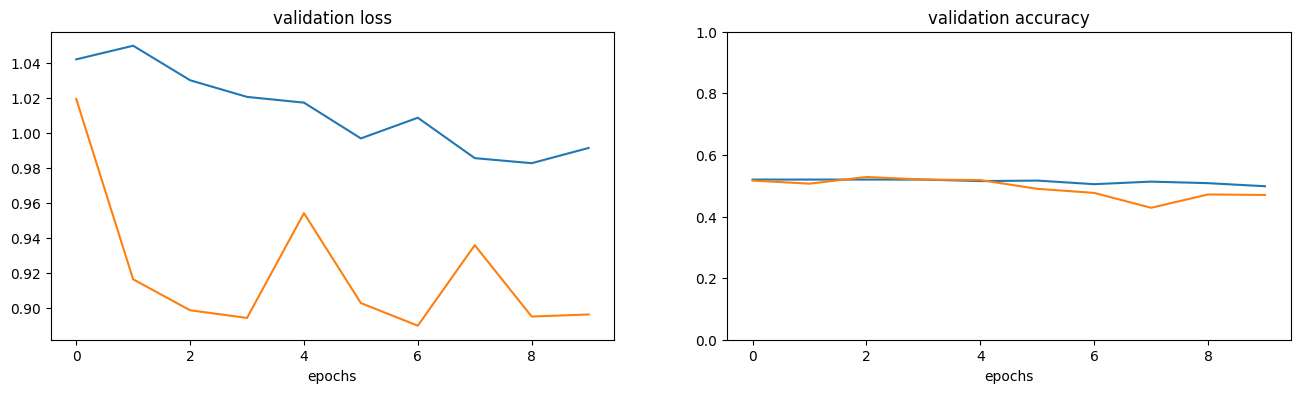

In [19]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Este código cria gráficos comparativos para observar o desempenho do modelo em termos de perda de validação (val_loss) e precisão de validação (val_accuracy) durante o treinamento, considerando os dois treinos realizados: o primeiro com o modelo base (history) e o segundo com o modelo ajustado (history2).

**Objetivo**

**Comparar o desempenho entre os dois treinamentos:**

O primeiro treinamento (history) representa o modelo base com todas as camadas ajustáveis.

O segundo treinamento (history2) é o modelo ajustado, onde apenas a última camada foi treinada.

**Ajuda a avaliar:**

Se houve melhoria na precisão (val_accuracy).

Se a perda de validação (val_loss) diminuiu, indicando melhor ajuste aos dados de validação.

**Configuração do gráfico principal:**

fig = plt.figure(figsize=(16,4))

Cria uma figura com tamanho de 16x4 polegadas para exibir os gráficos.

**Gráfico da perda de validação (Validation Loss):**

ax = fig.add_subplot(121)

ax.plot(history.history["val_loss"])

ax.plot(history2.history["val_loss"])

ax.set_title("validation loss")

ax.set_xlabel("epochs")

**fig.add_subplot(121):** Define o primeiro subplot para a perda de validação.

**ax.plot(history.history["val_loss"]):** Plota a curva de perda de validação do treinamento inicial.

**ax.plot(history2.history["val_loss"]):** Plota a curva de perda de validação do treinamento ajustado.

**ax.set_title("validation loss"):** Define o título do gráfico.

**ax.set_xlabel("epochs"):** Define o rótulo do eixo x como "epochs".

**Gráfico da precisão de validação (Validation Accuracy):**

ax2 = fig.add_subplot(122)

ax2.plot(history.history["val_accuracy"])

ax2.plot(history2.history["val_accuracy"])

ax2.set_title("validation accuracy")

ax2.set_xlabel("epochs")

ax2.set_ylim(0, 1)

**fig.add_subplot(122):** Define o segundo subplot para a precisão de validação.

**ax2.plot(history.history["val_accuracy"]):** Plota a curva de precisão de validação do treinamento inicial.

**ax2.plot(history2.history["val_accuracy"]):** Plota a curva de precisão de validação do treinamento ajustado.

**ax2.set_title("validation accuracy"):** Define o título do gráfico.

**ax2.set_xlabel("epochs"):** Define o rótulo do eixo x como "epochs".

**ax2.set_ylim(0, 1):** Restringe o eixo y entre 0 e 1, já que a precisão é uma métrica percentual.

In [20]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.8809177875518799
Test accuracy: 0.42595672607421875


In [26]:
img, x = get_image('G:/Meu Drive/cats_and_dogs/PetImages/Cat/45.jpg')
probabilities = model_new.predict([x])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
